In [92]:
# Import Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import gmaps
import os
import csv
import json
import scipy.stats as st
from config import (gkey)
import numpy as np
from scipy.stats import linregress
from census import Census
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=True)
from uszipcode import Zipcode
import requests


# Census API Key

from config import weather_api_key
from config import api_key

c = Census(api_key, year = 2013)

gmaps.configure(api_key=gkey)

#gmaps = googlemaps.Client(key = gkey)
#print(gkey)
# Range of latitudes and longitudes
Latitude = (-90, 90)
Longitude = (-180, 180)

In [93]:
# Reference the file where the CSV is located
crime_csv_path = "Resources/NYPD_Arrests_Data__Historic.csv"

# Import the data into a Pandas DataFrame
crime_df = pd.read_csv(crime_csv_path)
crime_df = crime_df.dropna()
crime_df
#Total numbers of crime recorder in NY is 5012956 and after the cleanup and Data engineering we came up with #4986619

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude
0,173130602,12/31/2017,566.0,"MARIJUANA, POSSESSION",678.0,MISCELLANEOUS PENAL LAW,PL 2210500,V,Q,105,0.0,25-44,M,BLACK,1063056.0,207463.0,40.735772,-73.715638
1,173114463,12/31/2017,478.0,"THEFT OF SERVICES, UNCLASSIFIED",343.0,OTHER OFFENSES RELATED TO THEFT,PL 1651503,M,Q,114,0.0,25-44,M,ASIAN / PACIFIC ISLANDER,1009113.0,219613.0,40.769437,-73.910241
2,173113513,12/31/2017,849.0,"NY STATE LAWS,UNCLASSIFIED VIOLATION",677.0,OTHER STATE LAWS,LOC000000V,V,K,73,1.0,18-24,M,BLACK,1010719.0,186857.0,40.679525,-73.904572
3,173113423,12/31/2017,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,M,18,0.0,25-44,M,WHITE,987831.0,217446.0,40.763523,-73.987074
4,173113421,12/31/2017,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,M,18,0.0,45-64,M,BLACK,987073.0,216078.0,40.759768,-73.989811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5012951,191717212,01/01/2019,244.0,"BURGLARY,UNCLASSIFIED,UNKNOWN",107.0,BURGLARY,PL 1402000,F,M,19,0.0,25-44,M,BLACK,994297.0,218680.0,40.766905,-73.963731
5012952,191717225,01/01/2019,922.0,"TRAFFIC,UNCLASSIFIED MISDEMEAN",348.0,VEHICLE AND TRAFFIC LAWS,VTL0511001,M,Q,113,0.0,25-44,M,BLACK HISPANIC,1049768.0,184837.0,40.673777,-73.763806
5012953,191719210,01/01/2019,759.0,"PUBLIC ADMINISTATION,UNCLASS M",359.0,OFFENSES AGAINST PUBLIC ADMINI,PL 1950500,M,K,77,0.0,25-44,M,BLACK,1001066.0,185066.0,40.674632,-73.939378
5012954,191719220,01/01/2019,439.0,"LARCENY,GRAND FROM OPEN AREAS, UNATTENDED",109.0,GRAND LARCENY,PL 1553004,F,S,120,0.0,<18,M,WHITE HISPANIC,962822.0,174282.0,40.645023,-74.077217


In [94]:
# Run Census Search to retrieve data on all zip codes for Bronx (Brough) (2013 ACS5 Census)
bronx_census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E","B19301_001E"
                          ), {'for': 'zip code tabulation area:10453, 10457, 10460,10458, 10467,10468,10451, 10452, 10456,10454, 10455, 10459, 10474,10463, 10471,10466, 10469, 10470, 10475,10461, 10462,10464, 10465, 10472, 10473'})

# Convert to DataFrame
bronx_census_pd = pd.DataFrame(bronx_census_data)

# Column Reordering
bronx_census_pd = bronx_census_pd.rename(columns={"B01003_001E": "Population",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "NAME": "Name", "zip code tabulation area": "Zipcode"})

# Final DataFrame
bronx_census_pd = bronx_census_pd[["Zipcode", "Population","Household Income",
                       "Per Capita Income"]]

# Visualize
#print(len(bronx_census_pd))
#Adding borough to census data
bronx_census_pd['Borough'] = bronx_census_pd.apply(lambda row:'Bronx',axis =1)
bronx_census_pd['Crime Rate'] = bronx_census_pd.apply(lambda row:'High',axis =1)

#calculationg the total population for bronx
bronx_sum_census_pd = pd.DataFrame(bronx_census_pd, columns =['Population'])
bronx_sum_column = bronx_sum_census_pd.sum()
#bronx_sum_column

#calculationg the mean for bronx
bronx_census_mean_pd = pd.DataFrame(bronx_census_pd, columns =['Per Capita Income'])
bronx_mean_column = bronx_census_mean_pd.mean().round(0)

#print(f" The total Population in Bronx is:{(bronx_sum_column)}")


In [95]:
# Run Census Search to retrieve data on all zip codes for Brooklyn (Brough) (2013 ACS5 Census)
Brooklyn_census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E","B19301_001E"
                          ), {'for': 'zip code tabulation area:11212, 11213, 11216, 11233, 11238,11209, 11214, 11228,11204, 11218, 11219, 11230,11234, 11236, 11239,11223, 11224, 11229, 11235,11201, 11205, 11215, 11217, 11231,11203, 11210, 11225, 11226,11207, 11208,11211, 11222,11220, 11232,11206, 11221, 11237'})

# Convert to DataFrame
Brooklyn_census_pd = pd.DataFrame(Brooklyn_census_data)

# Column Reordering
Brooklyn_census_pd = Brooklyn_census_pd.rename(columns={"B01003_001E": "Population",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "NAME": "Name", "zip code tabulation area": "Zipcode"})

# Final DataFrame
Brooklyn_census_pd = Brooklyn_census_pd[["Zipcode", "Population", "Household Income",
                       "Per Capita Income"]]

#Adding borough to census data
Brooklyn_census_pd['Borough'] = Brooklyn_census_pd.apply(lambda row:'Bronklyn',axis =1)
Brooklyn_census_pd['Crime Rate'] = Brooklyn_census_pd.apply(lambda row:'Extremely High',axis =1)
# Visualize
Brooklyn_census_pd.describe()

#calculationg the total population for Brooklyn
Brooklyn_sum_census_pd = pd.DataFrame(Brooklyn_census_pd, columns =['Population'])
Brooklyn_sum_column = Brooklyn_sum_census_pd.sum()
#Brooklyn_sum_column

#calculationg the mean for Brooklyn
Brooklyn_census_mean_pd = pd.DataFrame(Brooklyn_census_pd, columns =['Per Capita Income'])
Brooklyn_mean_column = Brooklyn_census_mean_pd.mean().round(0)
#Brooklyn_mean_column

#print(f" The total Population in Bronx is:{(Brooklyn_sum_column)}")

In [96]:
# Run Census Search to retrieve data on all zip codes for Manhattan (Brough) (2013 ACS5 Census)
Manhattan_census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E","B19301_001E",
                          ), {'for': 'zip code tabulation area:10026,10027,10030,10037,10039,10001,10011,10018,10019,10036,10029,10035,10010,10016,10017,10022,10012,10013,10014,10004,10005,10006,10007,10038,10280,10002,10003,10009,10021,10028,10044,10065,10075,10128,10021,10028,10044,10065,10075,10128,10023,10024,10025,10031,10032,10033,10034,10040'})

# Convert to DataFrame
Manhattan_census_pd = pd.DataFrame(Manhattan_census_data)

# Column Reordering
Manhattan_census_pd = Manhattan_census_pd.rename(columns={"B01003_001E": "Population",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "NAME": "Name", "zip code tabulation area": "Zipcode"})


# Final DataFrame
Manhattan_census_pd = Manhattan_census_pd[["Zipcode", "Population","Household Income",
                       "Per Capita Income"]]

#Adding borough to census data
Manhattan_census_pd['Borough'] = Manhattan_census_pd.apply(lambda row:'Manhattan',axis =1)
Manhattan_census_pd['Crime Rate'] = Manhattan_census_pd.apply(lambda row:'Very High',axis =1)

#Manhattan_census_pd = Manhattan_census_pd.astype(int)
#Manhattan_census_pd.dtypes

#calculationg the total population for Brooklyn
Manhattan_sum_census_pd = pd.DataFrame(Manhattan_census_pd, columns =['Population'])
Manhattan_sum_column = Manhattan_sum_census_pd.sum()
#Brooklyn_sum_column

#calculationg the mean for Brooklyn
Manhattan_census_mean_pd = pd.DataFrame(Manhattan_census_pd, columns =['Per Capita Income'])
Manhattan_mean_column = Manhattan_census_mean_pd.mean().round(0)
#Manhattan_mean_column
#Manhattan_census_pd.dtypes

#print(f" The total Population in Manhattan_mean_column is:{(Manhattan_mean_column)}")


In [97]:
# Run Census Search to retrieve data on all zip codes for Queens (Borough) (2013 ACS5 Census)
Queens_census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E","B19301_001E",
                          ), {'for': 'zip code tabulation area:11361, 11362, 11363, 11364,11354, 11355, 11356, 11357, 11358, 11360,11365, 11366, 11367,11412, 11423, 11432, 11433, 11434, 11435, 11436,11101, 11102, 11103, 11104, 11105, 11106,11374, 11375, 11379, 11385,11691, 11692, 11693, 11694, 11695, 11697,11004, 11005, 11411, 11413, 11422, 11426, 11427, 11428, 11429,11414, 11415, 11416, 11417, 11418, 11419, 11420, 11421,11368, 11369, 11370, 11372, 11373, 11377, 11378'})

# Convert to DataFrame
Queens_census_pd = pd.DataFrame(Queens_census_data)

# Column Reordering
Queens_census_pd = Queens_census_pd.rename(columns={"B01003_001E": "Population",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "NAME": "Name", "zip code tabulation area": "Zipcode"})
# Final DataFrame
Queens_census_pd = Queens_census_pd[["Zipcode", "Population","Household Income",
                       "Per Capita Income"]]

#Queens_census_pd.describe()

Queens_census_pd = Queens_census_pd.astype(int)
#Manhattan_census_pd.dtypes

#Adding borough to census data
Queens_census_pd['Borough'] = Queens_census_pd.apply(lambda row:'Queens',axis =1)
Queens_census_pd['Crime Rate'] = Queens_census_pd.apply(lambda row:'Low',axis =1)



#calculationg the total population for Brooklyn
Queens_sum_census_pd = pd.DataFrame(Queens_census_pd, columns =['Population'])
Queens_sum_column = Queens_sum_census_pd.sum()
#Brooklyn_sum_column

#calculationg the mean for Brooklyn
Queens_census_mean_pd = pd.DataFrame(Queens_census_pd, columns =['Per Capita Income'])
Queens_mean_column = Queens_census_mean_pd.mean().round(0)


In [98]:
# Run Census Search to retrieve data on all zip codes for Queens (Borough) (2013 ACS5 Census)
Staten_census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E","B19301_001E",
                          ), {'for': 'zip code tabulation area:10302, 10303, 10310,10306,10307,10308,10309,10312,10301,10304,10305,10314'})

# Convert to DataFrame
Staten_census_pd = pd.DataFrame(Staten_census_data)

# Column Reordering
Staten_census_pd = Staten_census_pd.rename(columns={"B01003_001E": "Population",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "NAME": "Name", "zip code tabulation area": "Zipcode"})
# Final DataFrame
Staten_census_pd = Staten_census_pd[["Zipcode", "Population","Household Income",
                       "Per Capita Income"]]

Staten_census_pd = Staten_census_pd.astype(int)
#Staten_census_pd.dtypes

#Adding borough to census data
Staten_census_pd['Borough'] = Staten_census_pd.apply(lambda row:'Staten Island',axis =1)
Staten_census_pd['Crime Rate'] = Staten_census_pd.apply(lambda row:'Very low',axis =1)

#calculationg the total population for Brooklyn
Staten_sum_census_pd = pd.DataFrame(Staten_census_pd, columns =['Population'])
Staten_sum_column = Staten_sum_census_pd.sum()
#Staten_sum_column

#calculationg the mean for Brooklyn
Staten_census_mean_pd = pd.DataFrame(Staten_census_pd, columns =['Per Capita Income'])
Staten_mean_column = Staten_census_mean_pd.mean().round()

#Staten_census_pd
#print(f" The total Population in Staten is:{(Staten_mean_column)}")

In [99]:
boro_pupolation = pd.concat([bronx_sum_column,Brooklyn_sum_column,Manhattan_sum_column,Queens_sum_column,Staten_sum_column], axis =1)
boro_pupolation.rename(index ={0:'bronx'}, columns={0:'Bronx'},inplace = True)
boro_pupolation.rename(index ={1:'Brooklyn'}, columns={1:'Brooklyn'},inplace = True)
boro_pupolation.rename(index ={2:'Manhattan'}, columns={2:'Manhattan'},inplace = True)
boro_pupolation.rename(index ={3:'Queens'}, columns={3:'Queens'},inplace = True)
boro_pupolation.rename(index ={4:'Staten'}, columns={4:'Staten'},inplace = True)
boro_census_pd = pd.DataFrame(boro_pupolation)

In [100]:
boro_mean = pd.concat([bronx_mean_column, Brooklyn_mean_column, Manhattan_mean_column,Queens_mean_column,Staten_mean_column], axis =1)
boro_mean.rename(index ={0:'bronx'}, columns={0:'Bronx'},inplace = True)
boro_mean.rename(index ={1:'Brooklyn'}, columns={1:'Brooklyn'},inplace = True)
boro_mean.rename(index ={2:'Manhattan'}, columns={2:'Manhattan'},inplace = True)
boro_mean.rename(index ={3:'Queens'}, columns={3:'Queens'},inplace = True)
boro_mean.rename(index ={4:'Staten'}, columns={4:'Staten'},inplace = True)
#boro_mean

In [101]:
crime_df[["mm", "day", "year"]] = crime_df["ARREST_DATE"].str.split("/", expand = True)
crime_df

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,...,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,mm,day,year
0,173130602,12/31/2017,566.0,"MARIJUANA, POSSESSION",678.0,MISCELLANEOUS PENAL LAW,PL 2210500,V,Q,105,...,25-44,M,BLACK,1063056.0,207463.0,40.735772,-73.715638,12,31,2017
1,173114463,12/31/2017,478.0,"THEFT OF SERVICES, UNCLASSIFIED",343.0,OTHER OFFENSES RELATED TO THEFT,PL 1651503,M,Q,114,...,25-44,M,ASIAN / PACIFIC ISLANDER,1009113.0,219613.0,40.769437,-73.910241,12,31,2017
2,173113513,12/31/2017,849.0,"NY STATE LAWS,UNCLASSIFIED VIOLATION",677.0,OTHER STATE LAWS,LOC000000V,V,K,73,...,18-24,M,BLACK,1010719.0,186857.0,40.679525,-73.904572,12,31,2017
3,173113423,12/31/2017,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,M,18,...,25-44,M,WHITE,987831.0,217446.0,40.763523,-73.987074,12,31,2017
4,173113421,12/31/2017,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,M,18,...,45-64,M,BLACK,987073.0,216078.0,40.759768,-73.989811,12,31,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5012951,191717212,01/01/2019,244.0,"BURGLARY,UNCLASSIFIED,UNKNOWN",107.0,BURGLARY,PL 1402000,F,M,19,...,25-44,M,BLACK,994297.0,218680.0,40.766905,-73.963731,01,01,2019
5012952,191717225,01/01/2019,922.0,"TRAFFIC,UNCLASSIFIED MISDEMEAN",348.0,VEHICLE AND TRAFFIC LAWS,VTL0511001,M,Q,113,...,25-44,M,BLACK HISPANIC,1049768.0,184837.0,40.673777,-73.763806,01,01,2019
5012953,191719210,01/01/2019,759.0,"PUBLIC ADMINISTATION,UNCLASS M",359.0,OFFENSES AGAINST PUBLIC ADMINI,PL 1950500,M,K,77,...,25-44,M,BLACK,1001066.0,185066.0,40.674632,-73.939378,01,01,2019
5012954,191719220,01/01/2019,439.0,"LARCENY,GRAND FROM OPEN AREAS, UNATTENDED",109.0,GRAND LARCENY,PL 1553004,F,S,120,...,<18,M,WHITE HISPANIC,962822.0,174282.0,40.645023,-74.077217,01,01,2019


In [102]:
#Creating a Data Frame for each Boro using the Boro code (Brooklyn K, Manhattan M, Bronx B, Queens Q, StatenIsland S)
#from 2006 to 2019.
crime_df_Brooklyn = crime_df[crime_df["ARREST_BORO"]=="K"]
crime_df_Manhattan = crime_df[crime_df["ARREST_BORO"]=="M"]
crime_df_Bronx = crime_df[crime_df["ARREST_BORO"]=="B"]
crime_df_Queens = crime_df[crime_df["ARREST_BORO"]=="Q"]
crime_df_StatenIsland = crime_df[crime_df["ARREST_BORO"]=="S"]


In [103]:
all_boro = pd.concat([boro_pupolation, boro_mean], ignore_index=True)

boro_all_pd = pd.DataFrame(all_boro)
boro_all_pd.rename(index ={0:'Population'},inplace = True)
boro_all_pd.rename(index ={1:'Per Capita Income'},inplace = True)
boro_all_pd


,Bronx,Brooklyn,Manhattan,Queens,Staten
Population,1397228.0,2539789.0,1583345.0,2256073.0,470223.0
Per Capita Income,19936.0,26758.0,70641.0,28876.0,31101.0


In [104]:
# Define function to Reverse geocode Lat,Lat
def get_zipcode(x):
    result = search.by_coordinates(lat = x['Latitude'], lng = x['Longitude'], returns = 1)
    return result[0].zipcode

##Geocode lat long and add new series for "Zip code" for Bronx, Brooklyn, Manhattan Crimes 2013.
# crime_df_Brooklyn_2013['zipcode'] = crime_df_Brooklyn_2013.apply(lambda x: get_zipcode(x), axis=1)
# crime_df_Bronx_2013['zipcode'] = crime_df_Bronx_2013.apply(lambda x: get_zipcode(x), axis=1)
# crime_df_Manhattan_2013['zipcode'] = crime_df_Manhattan_2013.apply(lambda x: get_zipcode(x), axis=1)

##Geocode lat long and add new series for "Zip code" for Bronx, Brooklyn, Manhattan Crimes 2019.
#crime_df_Brooklyn_2019['zipcode'] = crime_df_Brooklyn_2019.apply(lambda x: get_zipcode(x), axis=1)
# crime_df_Bronx_2019['zipcode'] = crime_df_Bronx_2019.apply(lambda x: get_zipcode(x), axis=1)
# crime_df_Manhattan_2019['zipcode'] = crime_df_Manhattan_2019.apply(lambda x: get_zipcode(x), axis=1)
# crime_df_Queens_2019['zipcode'] = crime_df_Queens_2019.apply(lambda x: get_zipcode(x), axis=1)
# crime_df_StatenIsland_2019['zipcode'] = crime_df_StatenIsland_2019.apply(lambda x: get_zipcode(x), axis=1)

##Saving Geocoded Bronx, Brooklyn, Manhattan Crimes 2013 as .CSV file.
# crime_df_Bronx_2013.to_csv("Resources/Bronx_2013_Crime.csv")
# crime_df_Brooklyn_2013.to_csv("Resources/Brooklyn_2013_Crime.csv")
# crime_df_Manhattan_2013.to_csv("Resources/Manhattan_2013_Crime.csv")

# #Saving Geocoded Bronx, Brooklyn, Manhattan, Queens, and Staten Island Crimes 2019 as .CSV file.
# crime_df_Bronx_2019.to_csv("Resources//2019/Bronx_2019_Crime.csv")
# crime_df_Brooklyn_2019.to_csv("Resources/2019/Brooklyn_2019_Crime.csv")
# crime_df_Manhattan_2019.to_csv("Resources/2019/Manhattan_2019_Crime.csv")
# crime_df_Queens_2019.to_csv("Resources/2019/Queens_2019_Crime.csv")
# crime_df_StatenIsland_2019.to_csv("Resources/2019/StatenIsland_2019_Crime.csv")

In [105]:
# Reference the file where the CSV is located for 2013 Crimes in Bronx, Brooklyn, and Manhattan
crime_csv_path_b2013 = "Resources/Bronx_2013_Crime.csv"
crime_csv_path_m2013 = "Resources/Manhattan_2013_Crime.csv"
crime_csv_path_br2013 = "Resources/Brooklyn_2013_Crime.csv"

# Import the data into a Pandas DataFrame
crime_df_Bronx_2013 = pd.read_csv(crime_csv_path_b2013)
crime_df_Manhattan_2013 = pd.read_csv(crime_csv_path_m2013)
crime_df_Brooklyn_2013 = pd.read_csv(crime_csv_path_br2013)

#Adding all csv to one Data Frame
#crime_df_bmbr = pd.concat([crime_df_b2013,crime_df_m2013,crime_df_br2013])

In [106]:
crime_df_Bronx_2013 

,Unnamed: 0,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,...,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,mm,day,year,zipcode
0,1328290,94254371,12/31/2013,511.0,"CONTROLLED SUBSTANCE, POSSESSION 7",235.0,DANGEROUS DRUGS,PL 2200300,M,B,...,M,WHITE HISPANIC,1007477.0,235474.0,40.812975,-73.916092,12,31,2013,10454
1,1328291,94250219,12/31/2013,244.0,"BURGLARY,UNCLASSIFIED,UNKNOWN TIME",107.0,BURGLARY,PL 1402000,F,B,...,F,BLACK HISPANIC,1007356.0,248923.0,40.849889,-73.916483,12,31,2013,10453
2,1328297,94254358,12/31/2013,779.0,"PUBLIC ADMINISTRATION,UNCLASSIFIED FELONY",126.0,MISCELLANEOUS PENAL LAW,PL 215510B,F,B,...,M,BLACK,1015091.0,254482.0,40.865123,-73.888499,12,31,2013,10458
3,1328298,94244274,12/31/2013,922.0,"TRAFFIC,UNCLASSIFIED MISDEMEAN",348.0,VEHICLE AND TRAFFIC LAWS,VTL0511001,M,B,...,F,BLACK,1008274.0,245226.0,40.839740,-73.913178,12,31,2013,10452
4,1328303,94254373,12/31/2013,259.0,"MISCHIEF,CRIMINAL UNCLASSIFIED 4TH DEG",351.0,CRIMINAL MISCHIEF & RELATED OFFENSES,PL 1450001,M,B,...,M,BLACK,1005871.0,242674.0,40.832741,-73.921871,12,31,2013,10452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85211,1722035,88358483,01/01/2013,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,B,...,M,BLACK,1012027.0,254322.0,40.864694,-73.899577,1,1,2013,10468
85212,1722045,88364147,01/01/2013,511.0,"CONTROLLED SUBSTANCE, POSSESSION 7",235.0,DANGEROUS DRUGS,PL 2200300,M,B,...,M,BLACK,1010872.0,250396.0,40.853922,-73.903768,1,1,2013,10457
85213,1722048,88364153,01/01/2013,244.0,"BURGLARY,UNCLASSIFIED,UNKNOWN TIME",107.0,BURGLARY,PL 1402501,F,B,...,M,WHITE HISPANIC,1013735.0,255974.0,40.869223,-73.893395,1,1,2013,10468
85214,1722051,88364175,01/01/2013,205.0,"TRESPASS 2, CRIMINAL",352.0,CRIMINAL TRESPASS,PL 1401500,M,B,...,M,WHITE HISPANIC,1016994.0,260146.0,40.880662,-73.881591,1,1,2013,10467


#  Brooklyn 2013 Income Vs Crime

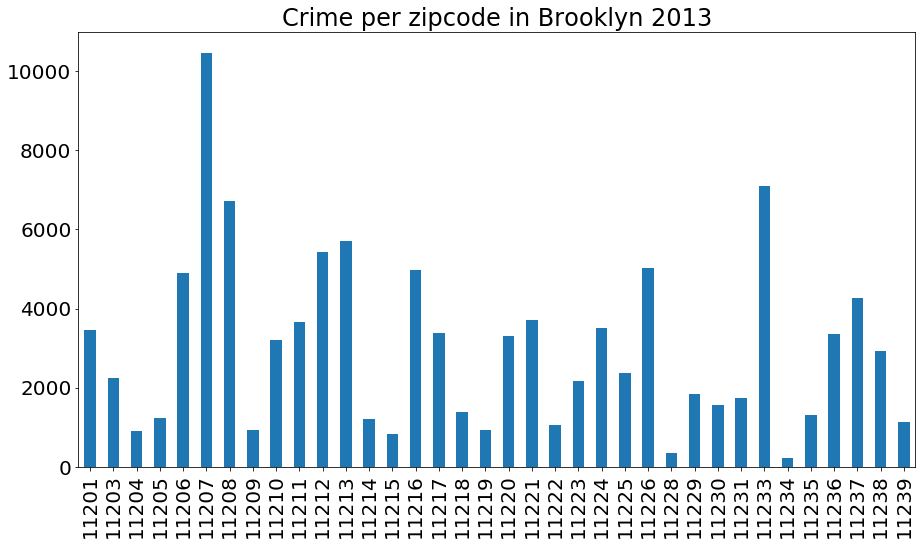

<Figure size 432x432 with 0 Axes>

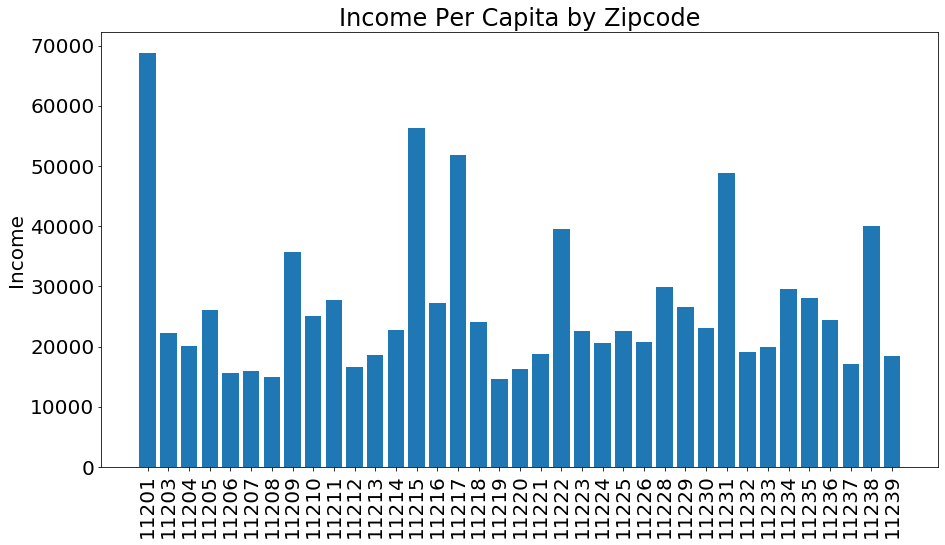

In [107]:
ZipBK = ["11212", "11213", "11216", "11233", "11238", "11209", "11214", "11228", "11204", "11218", "11219", "11230", "11234", "11236", "11239", "11223", "11224", "11229", "11235", "11201", "11205", "11215", "11217", "11231", "11203", "11210", "11225", "11226", "11207", "11208", "11211", "11222", "11220", "11232", "11206", "11221", "11237"]
sorted_df_brook = crime_df_Brooklyn_2013[crime_df_Brooklyn_2013['zipcode'].isin(ZipBK)]
Broklyn_2013_SORTED = sorted_df_brook.sort_values('zipcode')
plt.figure(figsize=(15,8))

Broklyn_2013_SORTED.groupby(['zipcode']).size().plot(kind = "bar", align="center")
plt.title("Crime per zipcode in Brooklyn 2013")
plt.ylabel("")
plt.xlabel("")
plt.show()
plt.tight_layout()

plt.figure(figsize=(15,8))
plt.title("Income Per Capita by Zipcode")
plt.ylabel("Income")
x = Brooklyn_census_pd["Zipcode"]
y = Brooklyn_census_pd["Per Capita Income"]
plt.bar(x,y);
plt.tick_params(axis='x', rotation=90)

# Manhattan 2013 Income Vs Crime

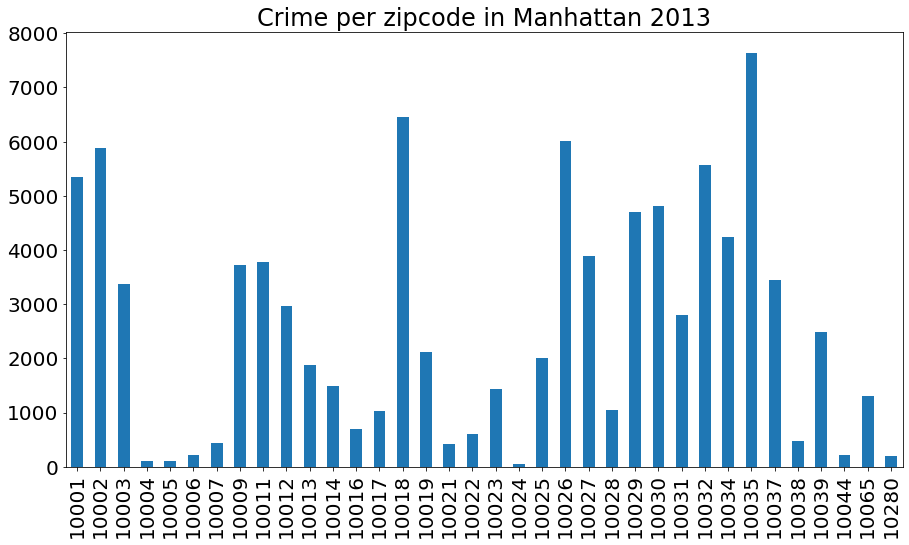

<Figure size 432x432 with 0 Axes>

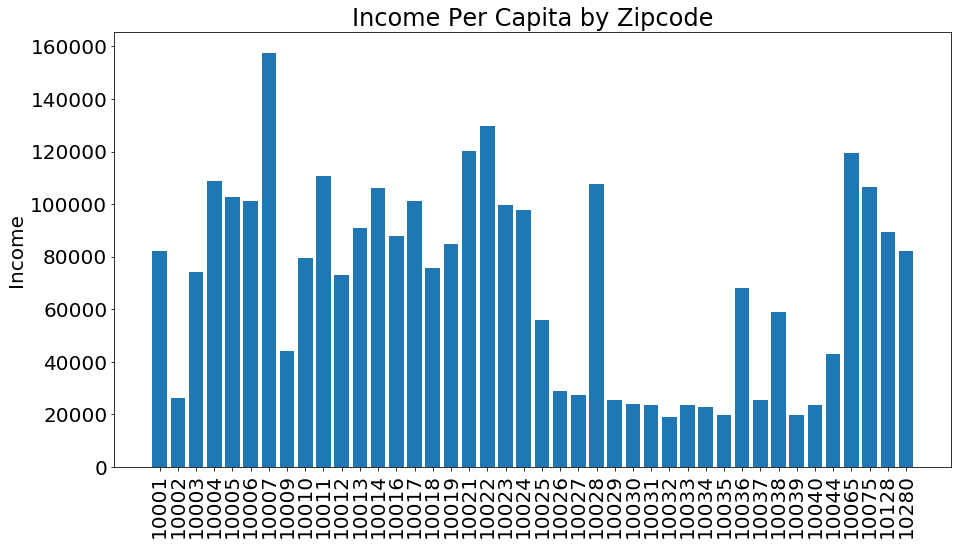

In [108]:
ZipMANH = ["10026", "10027", "10030", "10037", "10039", "10001", "10011", "10018", "10019", "10036", "10029", "10035", "10010", "10016", "10017", "10022", "10012", "10013", "10014", "10004", "10005", "10006", "10007", "10038", "10280", "10002", "10003", "10009", "10021", "10028", "10044", "10065", "10075", "10128", "10021", "10028", "10044", "10065", "10075", "10128", "10023", "10024", "10025", "10031", "10032", "10033","10034", "10040"]
sorted_df_MANH = crime_df_Manhattan_2013[crime_df_Manhattan_2013['zipcode'].isin(ZipMANH)]
Manhattan_2013_SORTED = sorted_df_MANH.sort_values('zipcode')
plt.figure(figsize=(15,8))

Manhattan_2013_SORTED.groupby(['zipcode']).size().plot(kind = "bar", align="center")
plt.title("Crime per zipcode in Manhattan 2013")
plt.ylabel("")
plt.xlabel("")
plt.show()
plt.tight_layout()

plt.figure(figsize=(15,8))
plt.title("Income Per Capita by Zipcode")
plt.ylabel("Income")
x = Manhattan_census_pd["Zipcode"]
y = Manhattan_census_pd["Per Capita Income"]
plt.bar(x,y);
plt.tick_params(axis='x', rotation=90)

# Bronx 2013 Income Vs Crime

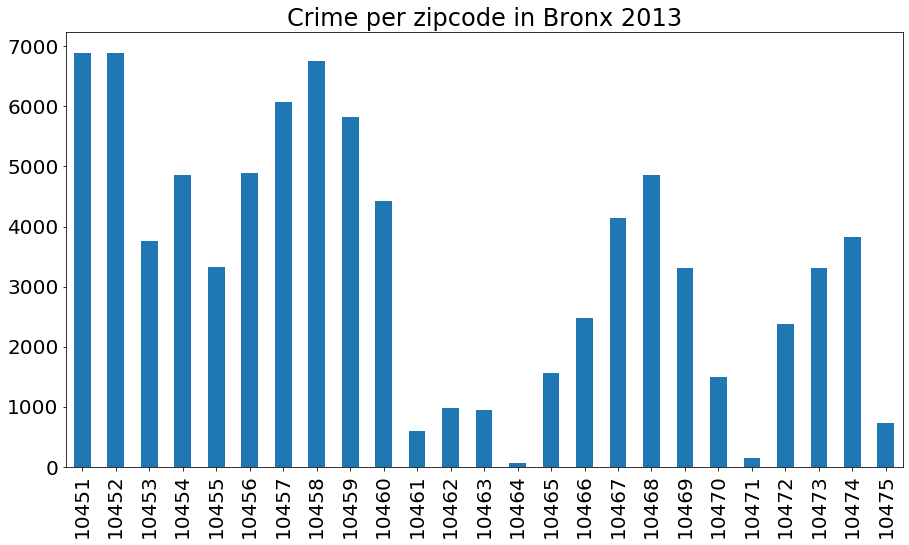

<Figure size 432x432 with 0 Axes>

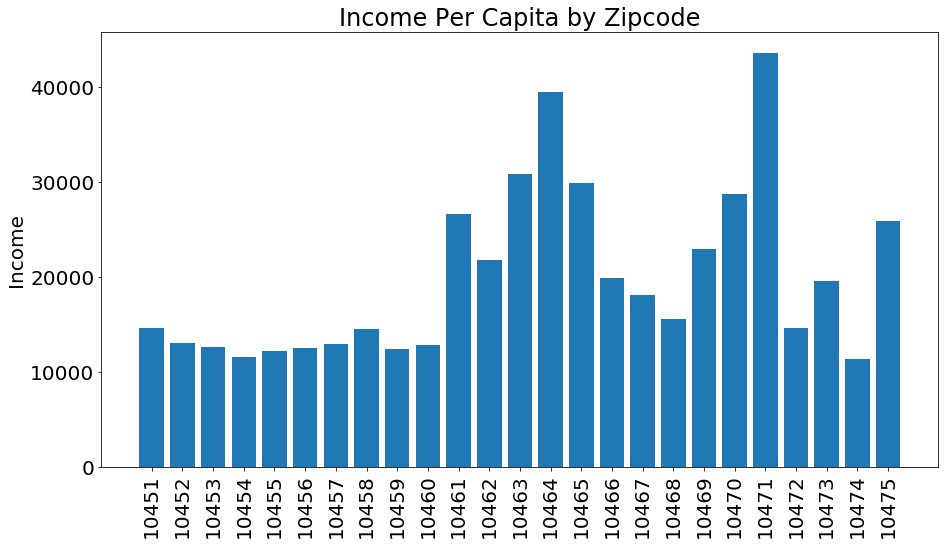

In [109]:
ZipBX = ["10453", "10457", "10460", "10458", "10467", "10468", "10451", "10452", "10456", "10454", "10455", "10459", "10474", "10463", "10471", "10466", "10469", "10470", "10475", "10461", "10462", "10464", "10465", "10472", "10473"]
sorted_df_bronx = crime_df_Bronx_2013[crime_df_Bronx_2013['zipcode'].isin(ZipBX)]
Bronx_2013_SORTED = sorted_df_bronx.sort_values('zipcode')
plt.figure(figsize=(15,8))

Bronx_2013_SORTED.groupby(['zipcode']).size().plot(kind = "bar", align="center")
plt.title("Crime per zipcode in Bronx 2013")
plt.ylabel("")
plt.xlabel("")
plt.show()
plt.tight_layout()

plt.figure(figsize=(15,8))
plt.title("Income Per Capita by Zipcode")
plt.ylabel("Income")
x = bronx_census_pd["Zipcode"]
y = bronx_census_pd["Per Capita Income"]
plt.bar(x,y);
plt.tick_params(axis='x', rotation=90)

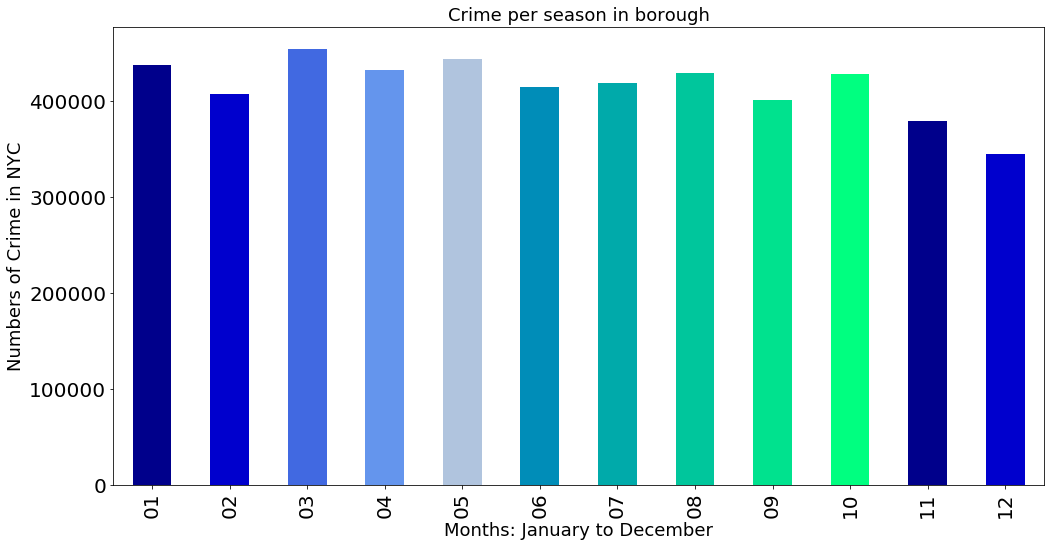

In [110]:
#The chat below is showing Crime per season in borough.

plt.figure(figsize=(15,8)) # setting the size of the Map

crime_df.groupby(['mm']).size().plot(kind = "bar", align="center", color = ['darkblue','mediumblue','royalblue','cornflowerblue','lightsteelblue','#008DB8','#00AAAA','#00C69C','#00E28E','#00FF80'])

plt.title("Crime per season in borough",fontsize = 18, color = 'black')
plt.ylabel("Numbers of Crime in NYC",fontsize = 18, color = 'black')
plt.xlabel("Months: January to December",fontsize = 18, color = 'black')

plt.tight_layout()

In [111]:
#Numbers of Crime per Borough from 2006 to 2019
grouped_df = crime_df.groupby( ["ARREST_BORO"] )
pd.DataFrame(grouped_df.size().reset_index(name = "Group_Count"))


,ARREST_BORO,Group_Count
0,B,1139917
1,K,1389738
2,M,1346959
3,Q,935181
4,S,174824


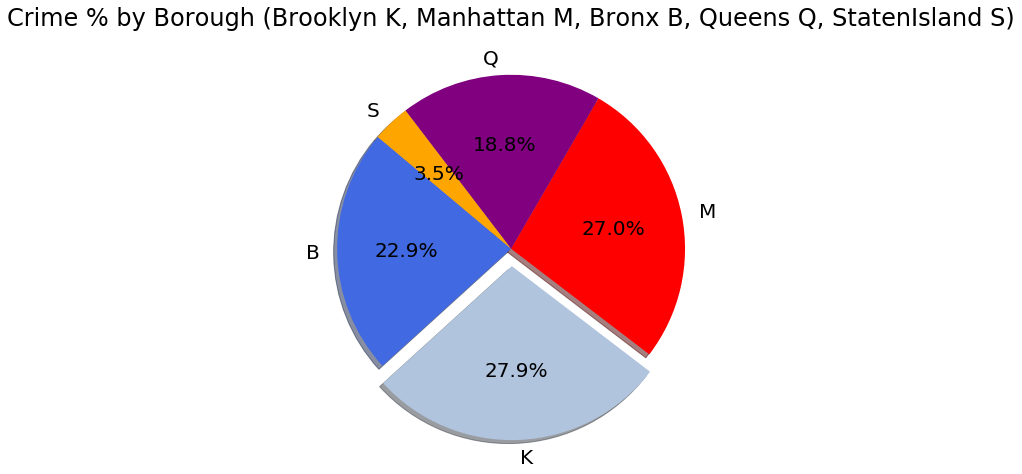

In [112]:
#Generating a Pie chart based on crime by Borough
colors=['royalblue','lightsteelblue','Red','Purple','Orange']
plt.figure(figsize=(15,8))
crime_boro = crime_df.groupby(['ARREST_BORO'])
crime_boro_plot = crime_boro['ARREST_BORO'].count()

crime_boro_plot_pie_df = pd.DataFrame({"Count":crime_boro_plot})
boro_count = crime_boro_plot_pie_df['Count'].tolist()
boro = crime_boro_plot_pie_df .index.get_level_values(0).tolist()
explode = (0, 0.1, 0, 0,0)

#Pie Chart
##Plotting Pie Chart
plt.pie(boro_count, shadow = True, startangle = 140, autopct = "%1.1f%%", labels = boro,  colors=colors, explode = explode)

#Labeling the graph with X,Y coordinates,titles and displaying with proper layout
plt.title("Crime % by Borough (Brooklyn K, Manhattan M, Bronx B, Queens Q, StatenIsland S)")

plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.size']=(16)
plt.show()


In [113]:
#Numbers of Crime per year in Borough
grouped_df = crime_df.groupby( ["year"] )
pd.DataFrame(grouped_df.size().reset_index(name = "Group_Count"))

,year,Group_Count
0,2006,370773
1,2007,402122
2,2008,400272
3,2009,419816
4,2010,420555
5,2011,410938
6,2012,393946
7,2013,391586
8,2014,385875
9,2015,337193


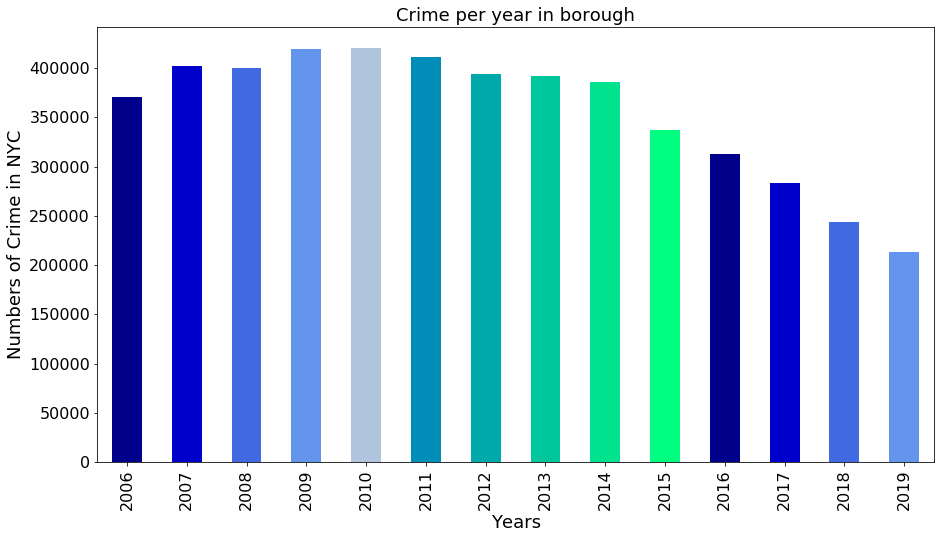

<Figure size 432x432 with 0 Axes>

In [114]:
##Barchat showing the Numbers of Crime per year in Borough
plt.figure(figsize=(15,8))
grouped_df = crime_df.groupby( ["year"] )
crime_df.groupby(["year"]).size().plot(kind="bar",color = ['darkblue','mediumblue','royalblue','cornflowerblue','lightsteelblue','#008DB8','#00AAAA','#00C69C','#00E28E','#00FF80'])

#Labeling the graph with X,Y coordinates,titles and displaying with proper layout
plt.title("Crime per year in borough",fontsize=18, color='black')
plt.ylabel("Numbers of Crime in NYC",fontsize=18, color='black')
plt.xlabel("Years",fontsize = 18, color = 'black')
plt.show()
plt.tight_layout()

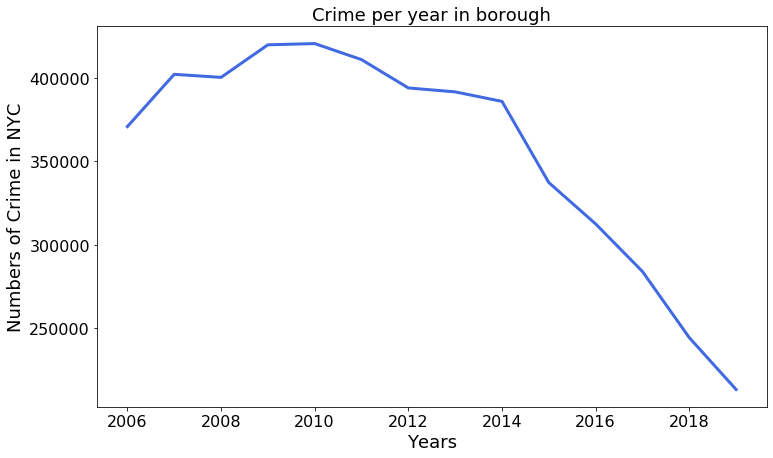

<Figure size 432x432 with 0 Axes>

In [115]:
#line chart showing Numbers of Crime per year in Borough
plt.figure(figsize=(20,10))
grouped_df = crime_df.groupby( ["year"] )
crime_df.groupby(["year"]).size().plot(linewidth=3, color='royalblue', figsize=(12, 7))
plt.title("Crime per year in borough",fontsize=18, color='black')
plt.ylabel("Numbers of Crime in NYC",fontsize=18, color='black')
plt.xlabel("Years",fontsize = 18, color='black')
plt.legend('',frameon = False)
plt.show()
plt.tight_layout()

In [116]:
#Numbers of Crime per Borough from 2006 to 2019 by Gender.
grouped_df = crime_df.groupby( ["PERP_SEX"] )
pd.DataFrame(grouped_df.size().reset_index(name = "Gender"))

,PERP_SEX,Gender
0,F,838655
1,M,4147964


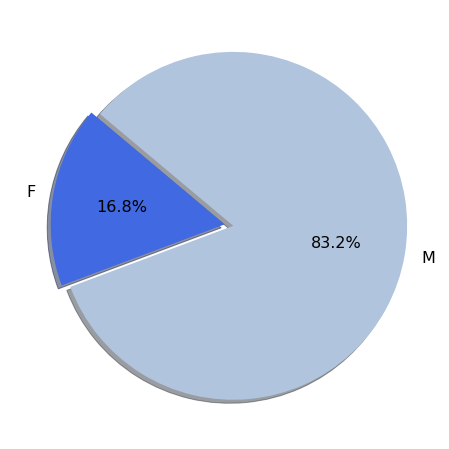

In [117]:
#Generating a Pie chart based on crime based on Gender

plt.figure(figsize=(15,8))
crime_boro_Gender = crime_df.groupby(['PERP_SEX'])
crime_boro_plot = crime_boro_Gender['PERP_SEX'].count()

crime_boro_plot_pie_df = pd.DataFrame({"Count":crime_boro_plot})
boro_count = crime_boro_plot_pie_df['Count'].tolist()
sex = crime_boro_plot_pie_df .index.get_level_values(0).tolist()
plt.legend('',frameon = False)
explode=(0,0.05)

#Pie Chart
plt.pie(boro_count, shadow = True, startangle = 140, autopct = "%1.1f%%", labels = sex,  colors=colors, explode = explode)

#Labeling the graph with X,Y coordinates,titles and displaying with proper layout
colors=['royalblue','lightsteelblue']

plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.size']=(20)


plt.show()

In [118]:
#Numbers of Crime per Borough from 2006 to 2019 based on type of race.
grouped_df = crime_df.groupby( ["PERP_RACE"] )
pd.DataFrame(grouped_df.size().reset_index(name = "Cases"))

,PERP_RACE,Cases
0,AMERICAN INDIAN/ALASKAN NATIVE,11026
1,ASIAN / PACIFIC ISLANDER,204225
2,BLACK,2421250
3,BLACK HISPANIC,400450
4,OTHER,1363
5,UNKNOWN,50126
6,WHITE,601403
7,WHITE HISPANIC,1296776


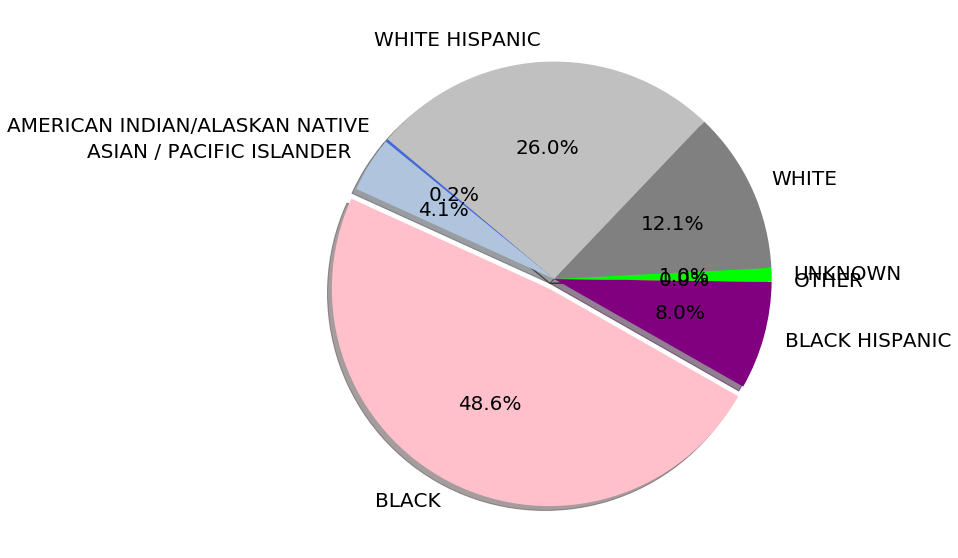

In [119]:
#Generating a Pie chart based on Race vs crime

plt.figure(figsize = (20,10))
explode=(0,0,0.05,0,0,0,0,0)

colors = ['royalblue','lightsteelblue','pink','Purple','Orange','lime','gray','silver']

crime_boro_Gender = crime_df.groupby(['PERP_RACE'])
crime_boro_plot = crime_boro_Gender['PERP_RACE'].count()

crime_boro_plot_pie_df = pd.DataFrame({"Count":crime_boro_plot})
boro_count = crime_boro_plot_pie_df['Count'].tolist()
sex = crime_boro_plot_pie_df .index.get_level_values(0).tolist()
plt.legend('',frameon = False)
#explode=(0,0.05)

#Pie Chart
plt.pie(boro_count, shadow = True, startangle = 140, autopct = "%1.1f%%", labels = sex,colors = colors, explode = explode  )

#Labeling the graph with X,Y coordinates,titles and displaying with proper layout


plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.size']=(20)


plt.show()

In [120]:
#Application to give you the information about any zipcode in New York
Borough_zipcode_df = pd.concat([Staten_census_pd,Queens_census_pd,Manhattan_census_pd,Brooklyn_census_pd,bronx_census_pd])
Borough_zipcode_df.to_csv("Resources/NYPD_Arrests.csv", index = False)

In [124]:
#Set path for file
csvpath = os.path.join("Resources","NYPD_Arrests.csv")

#Set variable to check if we found the video
found = False

#Entewr your zipcode
zip = input("What zipcode in NY you want info on? ")

#Save config information
units = "imperial" 
url = "http://api.openweathermap.org/data/2.5/weather?"

#Build query URL
query_url = url + "appid=" + weather_api_key + "&zip=" + zip + "&units=" + units

#print(query_url)

#Get weather data
weather_response = requests.get(query_url) 
weather_json = weather_response.json()



# Get temperature from JSON response
temp = weather_json["main"]["temp"]
pressure = weather_json["main"]["pressure"] 
humidity = weather_json["main"]["humidity"] 
geolon = weather_json["coord"]["lon"] 
geolat = weather_json["coord"]["lat"]

 # Set variable to check if we found the video
found = False

 # Open the CSV
with open(csvpath) as csvfile:
     csvreader = csv.reader(csvfile, delimiter=",")

    # Loop through looking for the video
     for row in csvreader:
        if row[0] == zip:
            #print(row[0] + " is in " + row[4] + " New York " + " with a Pupolation of " + row[1] +" Household Income of"+row[2]+
                 #" The crime rate is " + row[5])
            print("                            ")
            print("                         ")
            print(row[0] + " Zipcode Information")
            print("----------------------------")
            print(row[0] + " is in " + row[4] + " New York ")
            print(f"Pupolation is : " + row[1])
            print(f"Average Household Income is :  " + row[2])
            print(f"Average Per Capital Income is : " + row[3])
            print(f"Crime Rate is : " + row[5])
            print(f"Weather: Temp. {temp}F, Pressure {pressure}hpa, Geo Coords [{geolon},{geolat}], Humidity {humidity}% ")

             # Set variable to confirm we have found the video
            found = True

     # If the video is never found, alert the user
     if found == False:
        print("We don't seem to have that zipcode in New York State!")


What zipcode in NY you want info on? 11218
                            
                         
11218 Zipcode Information
----------------------------
11218 is in Bronklyn New York 
Pupolation is : 74758.0
Average Household Income is :  52445.0
Average Per Capital Income is : 24081.0
Crime Rate is : Extremely High
Weather: Temp. 78.69F, Pressure 1006hpa, Geo Coords [-73.98,40.64], Humidity 69% 


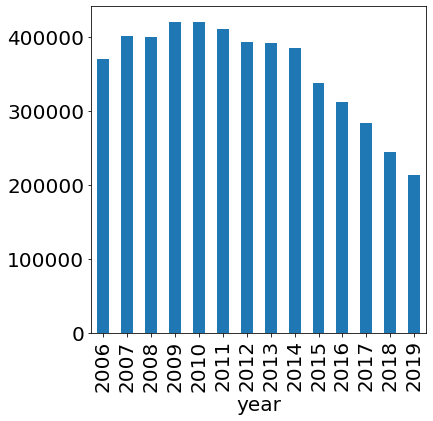

In [122]:
#Numbers of Crime per Year based on boro.
crime_df.groupby(["year"]).size().plot(kind="bar")

# Crimes per Year by Boro
crime_df_StatenIsland.groupby(["year"]).size().plot(kind="bar")
crime_df_Brooklyn.groupby(["year"]).size().plot(kind="bar")
crime_df_Manhattan.groupby(["year"]).size().plot(kind="bar")
crime_df_Bronx.groupby(["year"]).size().plot(kind="bar")
crime_df_Queens.groupby(["year"]).size().plot(kind="bar")


<Figure size 1440x720 with 0 Axes>

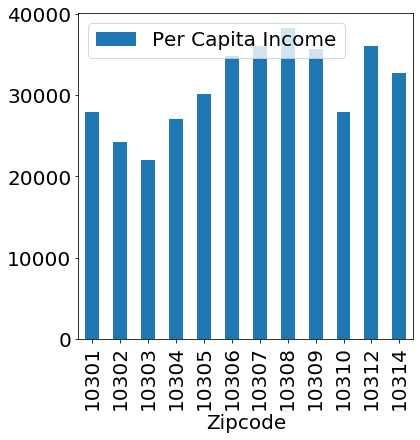

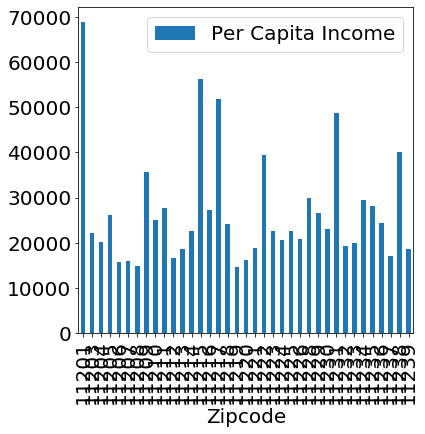

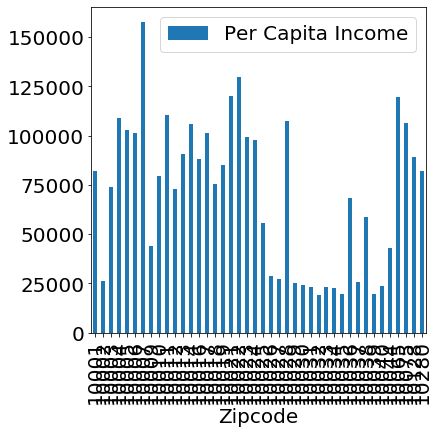

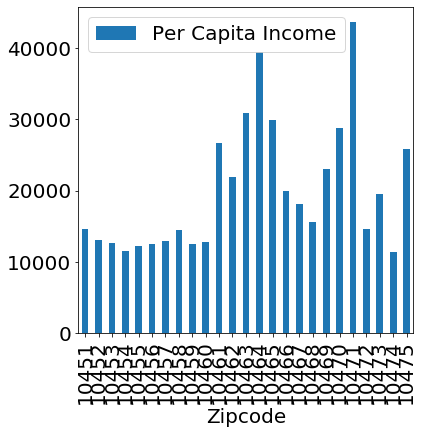

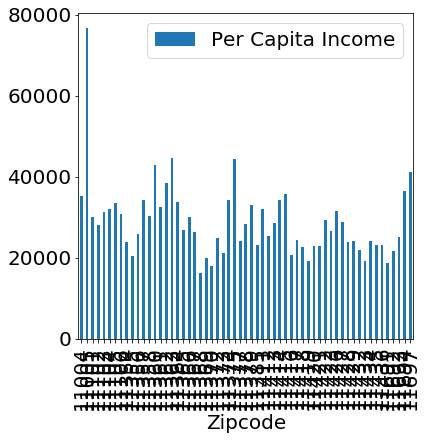

In [123]:
 #Income Per zip code by boro
plt.figure(figsize=(20,10))
Staten_census_pd.plot(x ="Zipcode", y = "Per Capita Income", kind = "bar")
Brooklyn_census_pd.plot(x ="Zipcode", y = "Per Capita Income", kind = "bar")
Manhattan_census_pd.plot(x ="Zipcode", y="Per Capita Income", kind = "bar")
bronx_census_pd.plot(x ="Zipcode", y="Per Capita Income", kind = "bar")
Queens_census_pd.plot(x ="Zipcode", y="Per Capita Income", kind = "bar")